In [1]:
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from scipy.spatial import distance
from scipy.optimize import curve_fit
from scipy.optimize import leastsq


In [2]:
imgs = np.array([cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                for path in glob.glob('./data/img/2021-12-20/train/*.jpg')])
avg_rows = np.mean(imgs, axis=1)
# avg_rows = np.median(imgs, axis=1)
specs_all = np.array([np.abs(np.fft.rfft(rows)) for rows in avg_rows])


In [3]:
TIMES_PER_POINT = 24


(6, 24, 541)
(6, 541)


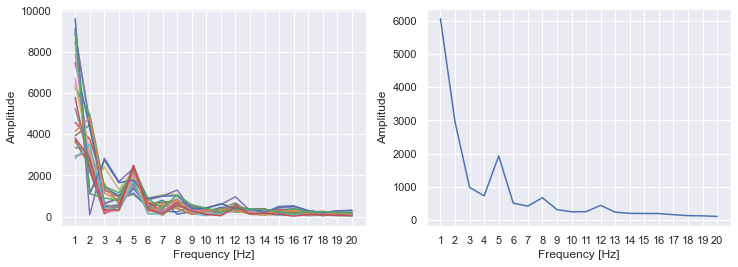

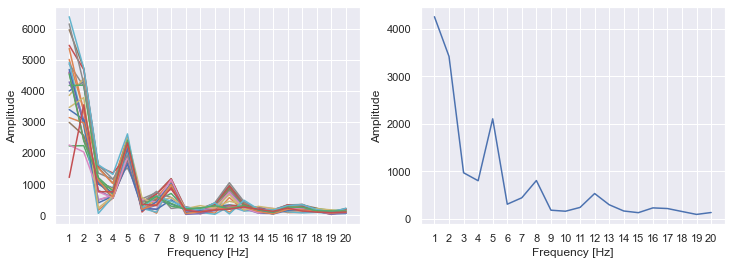

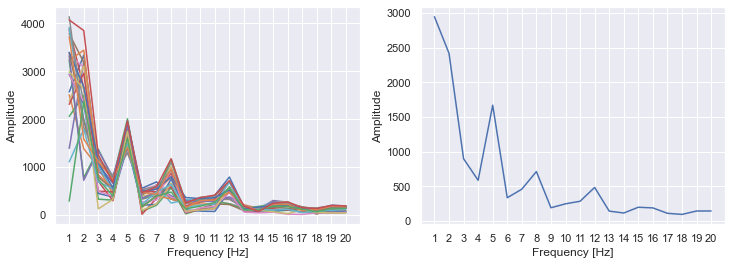

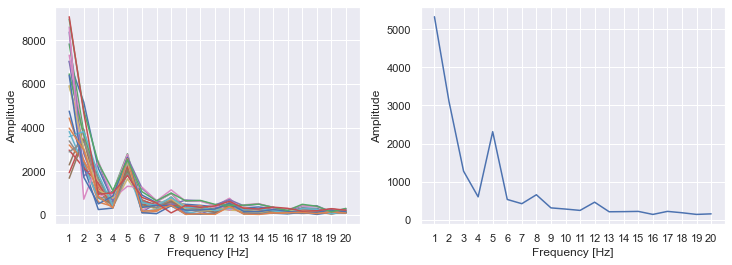

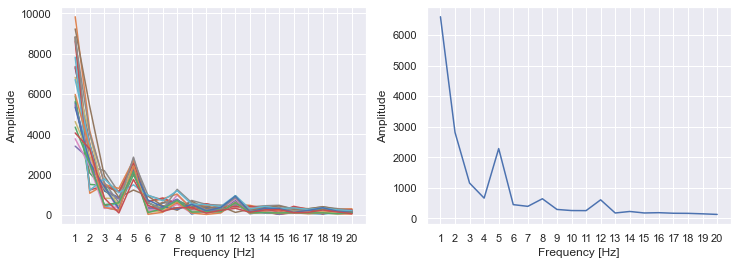

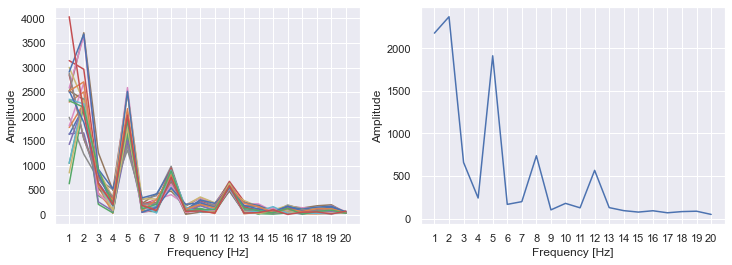

In [4]:
point_specs_list = np.reshape(
    specs_all, (len(specs_all)//TIMES_PER_POINT, TIMES_PER_POINT, -1))
print(point_specs_list.shape)
avg_spec_list = np.mean(point_specs_list, axis=1)
print(avg_spec_list.shape)

sns.set()
x = np.arange(1, 21)
for point_specs, avg_spec in zip(point_specs_list, avg_spec_list):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for specs in point_specs:
        axes[0].plot(x, specs[1:21])
    axes[1].plot(x, avg_spec[1:21])
    for ax in axes:
        ax.set_xticks(x)
        ax.set_xticklabels(x)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Amplitude')


In [5]:
# 実験環境の定数をここで定義する
# LEDの座標
LED_POSITIONS = [[1.0, 1.0], [2.0, 1.0],
                 [1.0, 2.0], [2.0, 2.0]]
# 使用する周波数ピークの位置
PEAK_POSITIONS = [2, 5, 8, 12]
# フィッティングの座標
# FITTING_POSITIONS = [[1.25, 1.0], [1.25, 1.25], [1.25, 1.5], [1.25, 1.75], [1.25, 2.0],
#                      [1.75, 1.0], [1.75, 1.25], [1.75, 1.5], [1.75, 1.75], [1.75, 2.0]]
FITTING_POSITIONS = [[1.25, 1.0], [1.25, 1.5], [1.25, 2.0],
                     [1.75, 1.0], [1.75, 1.5], [1.75, 2.0]]


In [6]:

class Led():
    def __init__(self, position, peak_pos) -> None:
        self.position = position
        self.peak_pos = peak_pos
        self.train_distances = []
        self.train_rss_list = []
        self.popt = [0, 0]
        self.test_rss_list = []

    def fitting(self):
        def theoreticalValue(x, a, b):
            f = a/(np.exp(np.pi*0.5*b*x)+np.exp(-np.pi*0.5*b*x))
            return f
        self.popt, self.pconv = curve_fit(
            theoreticalValue, self.train_distances, self.train_rss_list, p0=(5000, 0.5))

    def distance_quality(self, x):
        f = self.popt[0]/(np.exp(np.pi*0.5*self.popt[1]*x) +
                          np.exp(-np.pi*0.5*self.popt[1]*x))
        return f

    def get_distance(self, rss):
        dist = 2 * \
            (np.arccosh(0.5*self.popt[0]/rss)/(np.pi*np.abs(self.popt[1])))
        return np.nan_to_num(dist)


In [7]:
led_list = [Led(pos, peak) for pos, peak in zip(LED_POSITIONS, PEAK_POSITIONS)]
for led in led_list:
    print(led.position)


[1.0, 1.0]
[2.0, 1.0]
[1.0, 2.0]
[2.0, 2.0]


In [8]:
for led in led_list:
    led.train_distances = [distance.euclidean(led.position, fit_pos)
                           for fit_pos in FITTING_POSITIONS]
    led.train_rss_list = avg_spec_list[:, led.peak_pos]
    led.fitting()


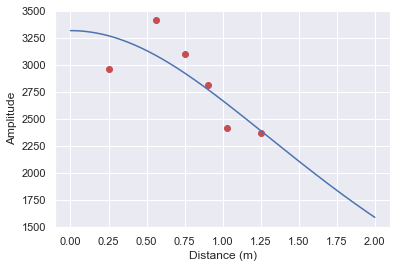

[6.63725242e+03 4.34868437e-01]


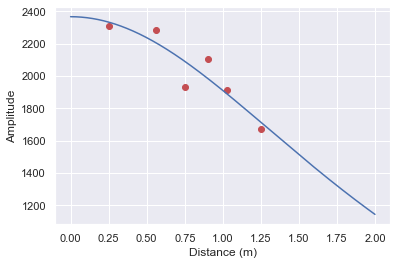

[4.73358703e+03 4.31387155e-01]


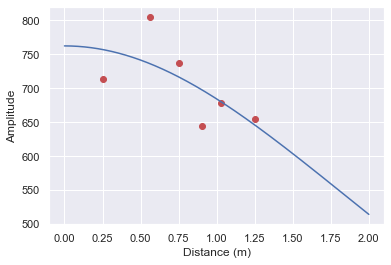

[1.52462242e+03 3.01278768e-01]


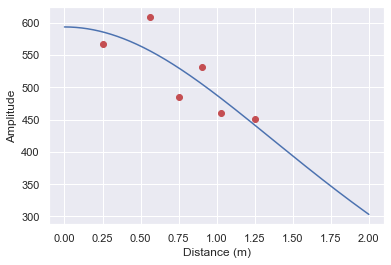

[1.18665351e+03 4.11072283e-01]


In [9]:
x = np.linspace(0, 2, 1000)
for led in led_list:
    plt.plot(led.train_distances, led.train_rss_list, 'ro')
    plt.plot(x, led.distance_quality(x), 'b')
    plt.xlabel('Distance (m)')
    plt.ylabel('Amplitude')
    plt.show()
    print(led.popt)


In [10]:
# TEST_POSITIONS = [[1.0, 1.0], [1.0, 1.5], [1.0, 2.0],
#                   [1.5, 1.0], [1.5, 1.5], [1.5, 2.0],
#                   [2.0, 1.0], [2.0, 1.5], [2.0, 2.0]]

TEST_POSITIONS = [[1.25, 1.25], [1.25, 1.75],
                  [1.75, 1.25], [1.75, 1.75]]

# TEST_POSITIONS = [[1.25, 1.0], [1.25, 1.25], [1.25, 1.5], [1.25, 1.75], [1.25, 2.0],
#                   [1.75, 1.0], [1.75, 1.25], [1.75, 1.5], [1.75, 1.75], [1.75, 2.0]]


In [11]:
test_imgs = np.array([cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                      for path in glob.glob('./data/img/2021-12-20/test/*.jpg')])
test_avg_rows = np.mean(test_imgs, axis=1)
# test_avg_rows = np.median(test_imgs, axis=1)
# test_avg_rows = np.mean(imgs[144:], axis=1)
test_specs = np.array([np.abs(np.fft.rfft(rows)) for rows in test_avg_rows])

test_point_specs_list = np.reshape(
    test_specs, (len(test_specs)//TIMES_PER_POINT, TIMES_PER_POINT, -1))
test_avg_spec_list = np.mean(test_point_specs_list, axis=1)

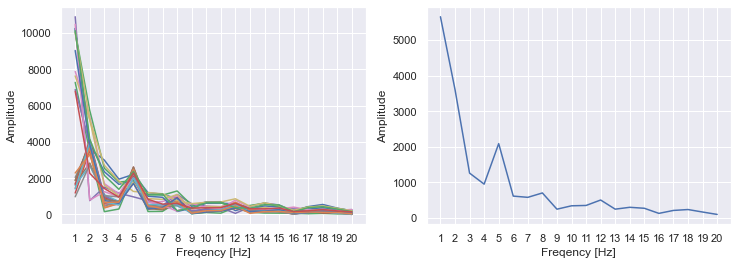

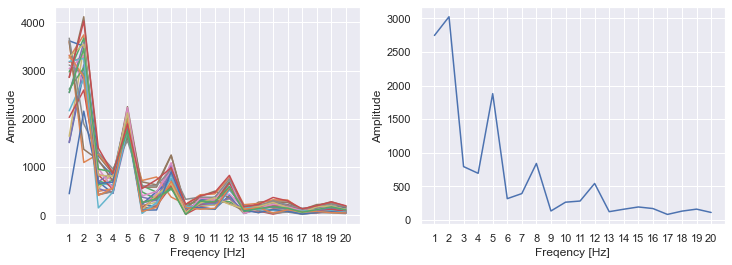

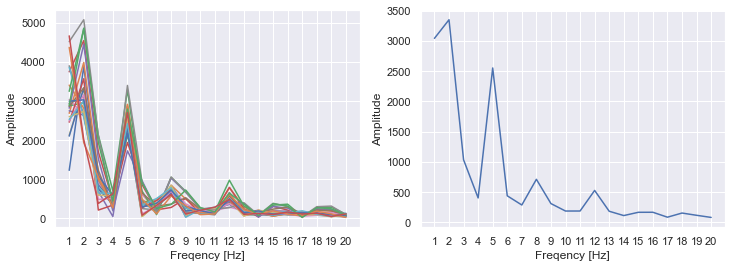

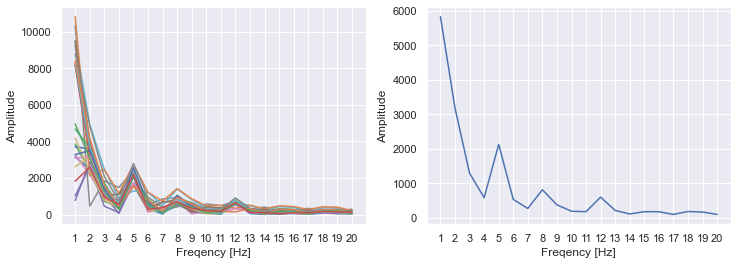

In [12]:
x = np.arange(1, 21)
for point_specs, avg_spec in zip(test_point_specs_list, test_avg_spec_list):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for specs in point_specs:
        axes[0].plot(x, specs[1:21])
    axes[1].plot(x, avg_spec[1:21])
    for ax in axes:
        ax.set_xticks(x)
        ax.set_xticklabels(x)
        ax.set_xlabel('Freqency [Hz]')
        ax.set_ylabel('Amplitude')


In [13]:
for led in led_list:
    led.test_rss_list = test_point_specs_list[:, :, led.peak_pos]
    print(led.test_rss_list.shape)
estimated_distances = np.array(
    [led.get_distance(np.mean(led.test_rss_list, axis=1)) for led in led_list]).T
print(estimated_distances.shape)


(4, 24)
(4, 24)
(4, 24)
(4, 24)
(4, 4)


C:\Users\ange0\AppData\Local\Temp/ipykernel_12432/3586161357.py:24: RuntimeWarning: invalid value encountered in arccosh
  (np.arccosh(0.5*self.popt[0]/rss)/(np.pi*np.abs(self.popt[1])))


In [14]:
def fitFunc(est_pos, est_dist, led_pos):
    residual = est_dist - \
        np.array([np.sqrt((est_pos[0]-led[0])**2+(est_pos[1]-led[1])**2)
                 for led in led_pos])
    return residual


initial_val = np.array([1.5, 1.5])
est_pos_list = np.array([leastsq(fitFunc, initial_val, args=(
    point, LED_POSITIONS))[0] for point in estimated_distances])
print(est_pos_list)


[[1.21286926 1.16072978]
 [1.18961247 1.79884777]
 [1.50559456 1.16338571]
 [1.45352564 1.72835361]]


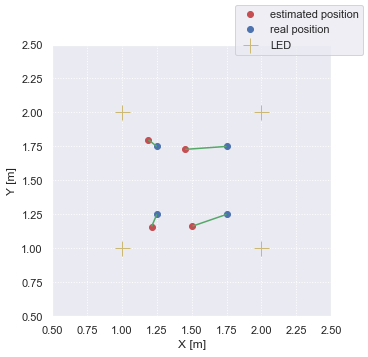

In [15]:
TEST_POSITIONS = np.array(TEST_POSITIONS)
LED_POSITIONS = np.array(LED_POSITIONS)

lines = [[est, real] for est, real in zip(est_pos_list, TEST_POSITIONS)]
lc = LineCollection(lines, colors="g")

fig, ax = plt.subplots(figsize=(5.0, 5.0))
ax.plot(est_pos_list[:, 0], est_pos_list[:, 1],
        "ro", label="estimated position")
ax.plot(TEST_POSITIONS[:, 0], TEST_POSITIONS[:, 1],
        "bo", label="real position")
ax.plot(LED_POSITIONS[:, 0], LED_POSITIONS[:, 1],
        "y+", label="LED", markersize=15,)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(0.5, 2.5)
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
fig.legend()
ax.grid(linestyle='dotted')
ax.add_collection(lc)


In [16]:
error_list = [np.sqrt((est_pos[0]-test_pos[0])**2+(est_pos[1]-test_pos[1])**2)
              for (est_pos, test_pos) in zip(est_pos_list, TEST_POSITIONS)]
print(error_list)
avg_error = np.mean(error_list)
print(avg_error)


[0.09668435174231413, 0.07767082989538072, 0.2592991576880612, 0.2972635443558348]
0.1827294709203977


In [17]:
times_estimated_distances = np.array(
    [led.get_distance(led.test_rss_list) for led in led_list]).transpose(1, 2, 0)
times_est_pos_list = np.array([[leastsq(fitFunc, initial_val, args=(
    time, LED_POSITIONS))[0]for time in point] for point in times_estimated_distances])
times_error_list = [[np.sqrt((est_pos[0]-test_pos[0])**2+(est_pos[1]-test_pos[1])**2) for est_pos in est_pos_times]
                    for (est_pos_times, test_pos) in zip(times_est_pos_list, TEST_POSITIONS)]
percentile_error = [np.percentile(pos, 90) for pos in times_error_list]
print(percentile_error)


[1.4263173045236923, 0.9119569730354341, 0.7402506596328391, 0.7361506082911963]


C:\Users\ange0\AppData\Local\Temp/ipykernel_12432/3586161357.py:24: RuntimeWarning: invalid value encountered in arccosh
  (np.arccosh(0.5*self.popt[0]/rss)/(np.pi*np.abs(self.popt[1])))


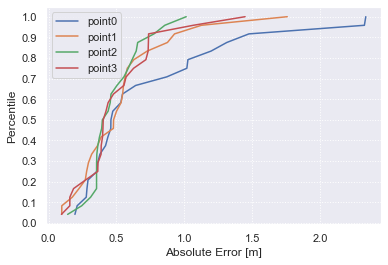

In [18]:
y_axis = []
for j in range(len(times_error_list[0])):
    y_axis.append((j+1)/len(times_error_list[0]))

for i, pos_err in enumerate(times_error_list):
    plt.plot(np.sort(pos_err), y_axis, label=f'point{i}')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5])
plt.xlabel('Absolute Error [m]')
plt.ylabel('Percentile')
plt.legend()
plt.grid(linestyle='dotted')
